<a href="https://colab.research.google.com/github/gelgel5633/self-study/blob/main/%ED%95%84%EC%82%AC/(2)Toxic_Comment_Classification_Challenge%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 출처
- competition : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge
- 노트북 링크 : https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda/notebook

## 업데이트 :  
새로운 테스트 및 학습 데이터에 대해 커널이 업데이트 되었습니다.

## 소개 :   
인터넷을 통해 익명을 유지하면 사람들이 평소에는 하지 않을 불쾌한 말을 하게 될 수 있습니다. 플랫폼에서 한 번에 하나의 댓글을 걸러내봅시다

## 목적 :    
유독성 댓글 분류를 위한 EDA, 피쳐 엔지니어링 노트북을 생성합니다

## 데이터 미리보기 :   
여기에 있는 데이터 세트는 인간 평가자가 독성에 대해 평가한 위키 말뭉치 데이터 세트에서 가져온 것입니다. corpus는 2004~2015년 까지 사용자 페이지 및 기사와 관련된 토론에서 6300만 개의 댓글이 포함되어 있습니다.   

플랫폼/사이트마다 process에 대한 표준이 다를수 있습니다. 따라서 댓글은 다음 5가지 범주로 태그가 지정됩니다.
- 유해(독성)
- 약간 유해
- 역겨운
- 위협
- 모욕
- 정체성 증오  


태깅은 크라우드소싱을 통해 수행되었는데, 이는 데이터 세트가 다른 사람들에 의해 평가되었으며 태깅도 100%정확하지 않을 수 있음을 의미합니다. 여기에서도 같은 우려가 논의되고 있습니다.   

원본 문서에는 데이터 세트 생성에 대한 더 흥미로운 세부 정보도 포함되어 있습니다.  
링크 : https://arxiv.org/pdf/1610.08914.pdf  


## 메모 :  테스트 셋에 대한 라벨링이 되어 있으므로 주최자가 새 데이터를 만드는 중입니다. 새 데이터에 대해 커널이 업데이트 되었습니다


In [1]:
# 요구되는 패키지
# 기본
import pandas as pd
import numpy as np

# 잡동사니 (misc)
import gc
import time
import warnings

# 통계
# from scipy.misc import imread
# scipy에서는 해당 기능을 지원하지 않으므로 imageio를 사용
from imageio import imread
from scipy import sparse
import scipy.stats as ss

# 시각화
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# 트윗 토크나이저는 우리가 원하는대로 인용부호로 분리되지 않습니다
from nltk.tokenize import TweetTokenizer

# 피쳐엔지니어링
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# 세팅
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
nltk.download("stopwords")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer  = TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# 데이터셋 불러오기
train  = pd.read_csv("/content/drive/MyDrive/transcription_data/Toxic Comment Classification Challenge/train.csv")
test = pd.read_csv("/content/drive/MyDrive/transcription_data/Toxic Comment Classification Challenge/test.csv")

In [3]:
# 일부 엿보기
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [4]:
nrow_train = train.shape[0]
nrow_test = test.shape[0]
sum = nrow_train + nrow_test
print("         : train : test")
print("rows     : ", nrow_train,":",nrow_test)
print("perc     : ",round(nrow_train*100/sum),"     :",round(nrow_test*100/sum))

         : train : test
rows     :  159571 : 153164
perc     :  51      : 49


30:70의 train:test로 나누어져있고 test셋은 미래에 변경될 수 있습니다.  
train셋의 클래스 불균형을 보겠습니다

### 클래스 불균형

In [5]:
x = train.iloc[:,2:].sum()
# 태그가 없는 comment를 clean으로 컬럼 설정
# axis = 1을 했을 때 각 컬럼에 대한 합이 아닌 각 행에 대한 합이 됨
rowsums = train.iloc[:,2:].sum(axis = 1)
train["clean"] = (rowsums==0)
# clean 데이터의 수 계산
train["clean"].sum()
print("전체 comments = ", len(train))
print("전체 clean comments = ", train["clean"].sum())
print("전체 태그 = ", x.sum())

전체 comments =  159571
전체 clean comments =  143346
전체 태그 =  35098


In [6]:
print("train에서 결측치 체크")
null_check = train.isnull().sum()
print(null_check)
print("test에서 결측치 체크")
null_check = test.isnull().sum()
print(null_check)
print("결측값을 \"unknown\" 으로 채웁니다")
train["comment_text"].fillna("unknown", inplace = True)
test["comment_text"].fillna("unknown", inplace = True)

train에서 결측치 체크
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
test에서 결측치 체크
id              0
comment_text    0
dtype: int64
결측값을 "unknown" 으로 채웁니다


- 밑의 rect에 대한 부분에 대한 이해가 필요하여 정리했습니다. 
1. plot 객체를 ax로 초기화하였습니다.
2. ax.patches 를 rects로 초기화하였습니다  
2-1. patches의 값은 각 막대그래프입니다.
3. rects.xxx 로 값을 얻을 수 있습니다.  
3-1. rects.get_height()은 그래프의 높이를 얻습니다  
3-2. rects.get_width()로 그래프의 좌우 넓이를 얻습니다  
3-3. rects.get_x()로 바의 왼쪽 아랫부분을 구할 수 있습니다.  
참고링크 : https://suy379.tistory.com/m/148

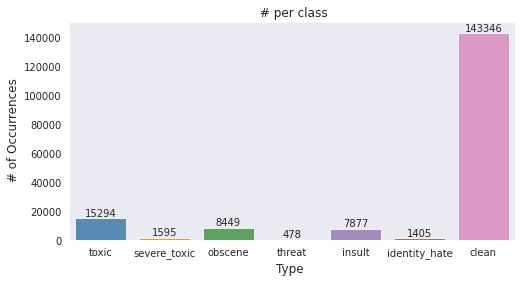

In [7]:
# 아래 x는 series 데이터 형태입니다.
x = train.iloc[:,2:].sum()
#plot 그리기
plt.figure(figsize = (8,4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title(" # per class")
plt.ylabel(" # of Occurrences", fontsize = 12)
plt.xlabel("Type ", fontsize = 12)
# 텍스트라벨 추가
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")

plt.show()

- 독성은 클래스 간 고르게 퍼져있지 않습니다. 우리는 클래스 불균형 문제에 직면할 수 있습니다.
- train셋에는 95000의 comment가 있고, 21000개의 태그와, 86000개의 깨끗한 comment가 있습니다.
    - 이는 각 댓글에 여러 태그가 연결된 경우에만 가능합니다. (예 : 댓글이 유해 + 음란 으로 분류될 수 있습니다)  

__멀티태깅 :__ 
얼마나 많은 comment가 multi tagging이 되어있는지 확인해봅시다

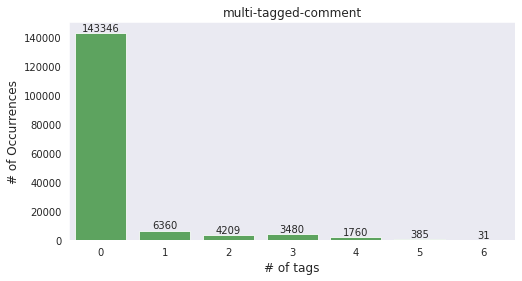

In [8]:
x=rowsums.value_counts()

#plot
plt.figure(figsize = (8,4))
# 위에서 설정한 적이 있습니다 color = sns.color_palette()
# 색에 대한 참고는 다음 링크에서 가능합니다 : https://seaborn.pydata.org/generated/seaborn.color_palette.html
ax = sns.barplot(x.index, x.values, alpha = 0.8, color = color[2])
plt.title("multi-tagged-comment")
plt.ylabel("# of Occurrences", fontsize = 12)
plt.xlabel("# of tags", fontsize = 12)

#텍스트 라벨 추가
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height +5, label, ha="center", va = "bottom")

plt.show()

전체 댓글의 10% 이하만이 어떤 종류의 독성을 가지고 있습니다.
모든 것에 해당하는 특정 댓글(20) 이 있습니다.  
(31개인데 왜 20으로 표시를 했을까...?)  

### 어떤 태그가 함께 사용될까요?  
태그가 함께 발생하는 빈도를 살펴보겠습니다. 이에 대한 좋은 지표는 상관관계 도표입니다.

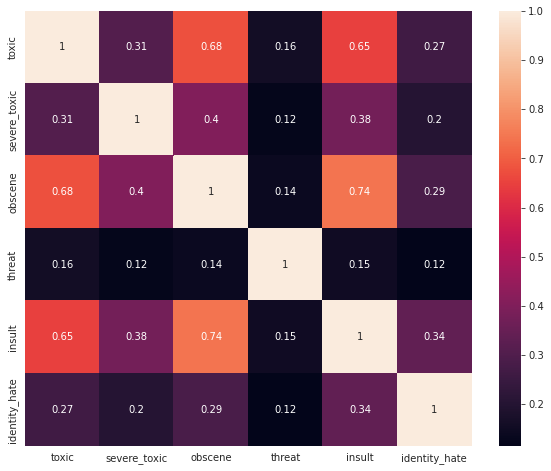

In [9]:
temp_df = train.iloc[:,2:-1]
# clean을 제외한 모든 항목에 대하여 가져옵니다
# temp_df = temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,xticklabels = corr.columns.values, yticklabels = corr.columns.values, annot = True)

위의 플롯은 동시 발생 패턴을 나타내지만 관련된 변수가 범주형(이진)변수이기 떄문에 피어슨 상관관계를 사용하는 pandas의 기본 corr함수는 여기에 적용되지 않습니다.  

따라서 두 범주형 변수 사이의 패턴을 찾기 위하여 다음과 같은 다른 도구를 사용할 수 있습니다
- 혼동행렬/ 크로스탭(피벗 테이블의 한 종류)
- cramer의 V 통계
    - cramer의 V통계는 연관성의 정도/강도도 측정되는 카이제곱 검정의 확장입니다

- 크래머 V계수란?
    - 카이제곱 독립성 검정의 효과 크기 측정
        1. 어떤 필드가 가장 작은 수의 카테고리를 가지는지 판별
        2. 해당 필드에 있는 카테고리 수에서 1을 뺌
        3. 2의 결과에 레코드의 총 수를 곱함
        4. 카이제곱 값을 이전 결과로 나눔. 카이제곱값은 카이 제곱 독립성 검정으로 부터 얻음
        5. 제곱근을 취함
    - 효과크기(ES)
        - 0.2이하 : 결과가 약함. 통계적으로 유의하더라도 약하게 연관됨
        - 0.6이하 : 결과가 적당
        - 0.6초과 : 결과가 강력. 필드가 강하게 연관됨

In [10]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color = "yellow"):
    """
    시리즈나 데이터프레임에 최댓값을 강조합니다
    """
    attr = "background-color: {}".format(color)
    if data.ndim == 1: # axis = 1이거나 .apply(axis=0) 인 시리즈
        is_min = data == data.min()
        return [attr if v else "" for v in is_min]
    else: # .apply(axis = None) 인 경우
    #is_max를 지정은 하는데 사용하는 곳이 없음 -> np.where(is_min)을 np.where(is_max)로 변경
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_max, attr, ""), index = data.index, columns = data.columns)

In [11]:
# crosstab
# 기술적으로 모든 6개 클래스 간의 교차 분석은 시각화하는 것이 불가능하므로 다른 태그와 함께 toxic을 보겠습니다
main_col= "toxic"
corr_mats = []
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)

out = pd.concat(corr_mats, axis = 1, keys = temp_df.columns[1:])

#셀 강조
out = out.style.apply(highlight_min, axis = 0)
out

위의 표는 다른 클래스와 함께 유독성 댓글의 교차분석/ 혼동행렬을 나타냅니다  
흥미로운 부분이 있습니다.
- 심각한 유해성 댓글은 항상 유해합니다. 
- 다른 클래스는 몇 가지 예외 클래스를 제외하고는 독성의 하위 집합인 것 같습니다

In [12]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """
    범주형 변수 간에 크래머 V계수를 계산합니다
    bergsma와 wicher의 개선을 사용합니다
    """
    ## ss = scipy.stats
    ## 카이제곱검정을 할 때 리턴값은 카이제곱, p-value, 자유도 총 3가지
    ## 이 중에서 카이제곱 값만 chi2로 리턴을 받음
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/ n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
    rcorr = r - ((r-1) **2) / (n-1)
    kcorr = k - ((k-1) **2) / (n-1)
    return np.sqrt(phi2corr/ min((kcorr-1), (rcorr-1)))

In [13]:
# 유해성과 다소유해 체크
col1 = "toxic"
col2 = "severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("유해와 다소유해의 혼동행렬")
print(confusion_matrix)

new_corr = cramers_corrected_stat(confusion_matrix)
print("유해와 다소 유해의 상관관계를 사용한 크래머 계수 = ", new_corr)

유해와 다소유해의 혼동행렬
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
유해와 다소 유해의 상관관계를 사용한 크래머 계수 =  0.30850290540548614


### 예제 comments

In [14]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [15]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [16]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [17]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [18]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


많은 유해성이 있습니다. 이상한점 발견  

- 일부 댓글은 극단적이고 동일한 내용을 복사한 것입니다
- 댓글에는 여전히 IP주소, 사용자 이름 및 일부 미스터리 번호(작성자는 기사 id라고 가정)를 포함할 수 있습니다.  

두 가지 포인트는 과적합을 일으킬 수 있습니다

### 워드클라우드 - 단어 빈도:
이러한 클래스와 관련된 단어를 살펴보겠습니다.  

차트 설명 : 단어 구름은 높은 빈도를 가질수록 더 커집니다. 단어 구름을 만드는 멋진 방법이 여기 있습니다. 여기에는 다음 단계가 포함됩니다.  
```
- 이미지 및 기본 64 인코딩 검색
- 인코딩을 셀에 붙여넣고 코덱 패키지를 사용하여 이미지로 변환
- 새 이미지를 마스크로 사용하여 단어구름 생성
```

더 간단한 방법은 새 kaggle 데이터를 만들고 거기에서 이미지를 가져오는 것입니다

In [19]:
stopword = set(STOPWORDS)

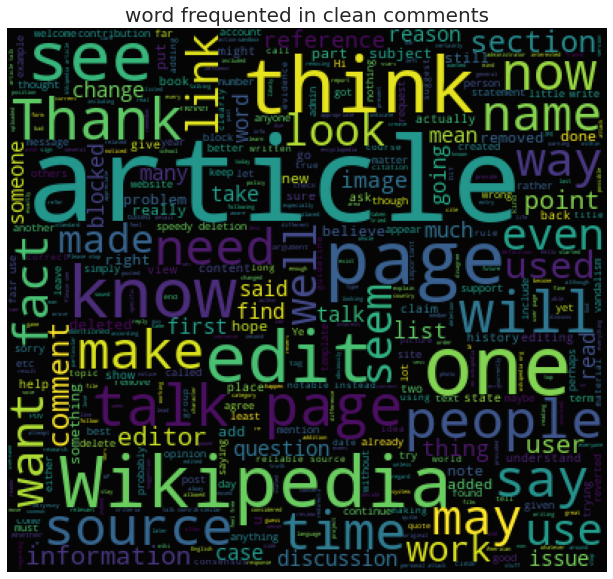

In [20]:
# comment cleanning
clean_mask = np.array(Image.open("/content/drive/MyDrive/transcription_data/Toxic Comment Classification Challenge/black.png"))
clean_mask = clean_mask[:,:,1]
# clean comment를 위한 단어구름
subset = train[train.clean==True]
text=subset.comment_text.values
wc = WordCloud(background_color = "black", max_words = 2000, mask = clean_mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize = (15,10))
plt.axis("off")
plt.title("word frequented in clean comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = "viridis", random_state = 17), alpha = 0.98)
plt.show()

# 피쳐 엔지니어링:
피쳐 엔지니어링 아이디어를 다음 세 그룹으로 광범위하게 분류하였습니다.

- 직접적인 기능:
    - 단어빈도 피쳐
        - 피쳐 갯수 세기
        - bigrams
        - trigrams
    - 단어의 벡터거리 매핑(예:word2vec)
    - 감정 점수

- 간접적인 기능: 실험적인 기능이 있습니다
    - 문장의 수
    - 단어의 수
    - 고유 단어의 수
    - 글자수
    - 구둣점의 수
    - 대문자/단어의 수
    - 불용어의 수
    - 각 단어의 평균 길이

- 누수 특성 : 예제에서 comment에 ip, 사용자이름 등이 포함되어 있음을 알 수 있습니다. 우리는 그것들로붕터 피쳐를 만들 수 있지만, wikipedia 사용 사례에 과적합으로 이어질 것입니다.  
    - 유해 사용자
    - 유해 ip  
         간접 및 누출 피쳐를 먼저 생성하세요. 두 가지 이유가 있습니다.
        - 카운트 기반은 깨끗한 말뭉치에서 생성된 경우에만 유용합니다.
        - 또한 간접기능은 데이터 세트를 정리할 때 정보 손실을 보상하는 데 도움이 됩니다

In [21]:
merge = pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df = merge.reset_index(drop = True)

In [22]:
# 간접 피쳐

# 각 comment에 대해 문장 count
# "\n" 은 각 comment별 문장의 수를 셀 때 사용할 수 있습니다
df['count_sent'] = df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
# 각 comment별 단어 카운트
df['count_word'] = df["comment_text"].apply(lambda x: len(str(x).split()))
# 고유 단어 카운트
df['count_unique_word'] = df["comment_text"].apply(lambda x: len(set(str(x).split())))
# 문자수 카운트
df['count_letters'] = df["comment_text"].apply(lambda x: len(str(x)))
# 구둣점 카운트
df["count_punctuations"] = df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# 대문자 카운트
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# 첫 글자 중 대문자
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# 불용어의 수
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
# 단어의 평균 길이
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [23]:
# 파생된 피쳐
# 각 comment로부터 단어 퍼센트 카운트
df["word_unique_percent"] = df["count_unique_word"] * 100 / df["count_word"]
# 각 comment별 구둣점 퍼센트
df["punct_percent"] = df["count_punctuations"] * 100 / df["count_word"]

In [24]:
# train, test 피쳐 분리
train_feats = df.iloc[0:len(train),]
test_feats = df.iloc[len(train):,]
# 태그 join
train_tags = train.iloc[:,2:]
train_feats = pd.concat([train_feats, train_tags], axis = 1)

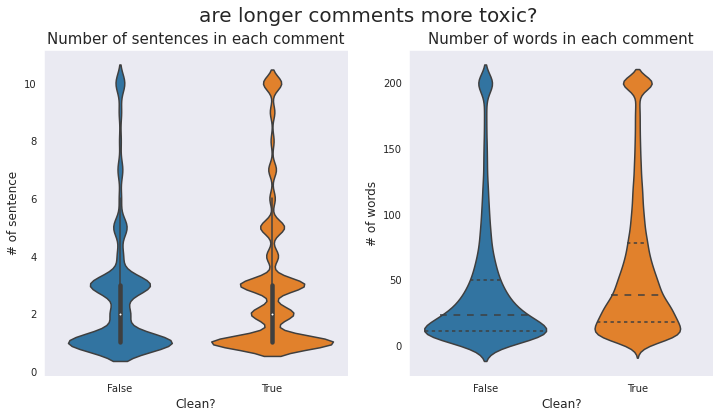

In [25]:
train_feats["count_sent"].loc[train_feats["count_sent"]>10] = 10
plt.figure(figsize = (12,6))
# 문장
plt.subplot(121)
plt.suptitle("are longer comments more toxic?", fontsize = 20)
sns.violinplot(y = "count_sent", x = "clean", data = train_feats, split = True)
plt.xlabel("Clean?", fontsize =12)
plt.ylabel(" # of sentence ", fontsize = 12)
plt.title("Number of sentences in each comment", fontsize = 15)
# 단어
train_feats["count_word"].loc[train_feats["count_word"]>200] = 200
plt.subplot(122)
sns.violinplot(y = "count_word", x = "clean", data = train_feats, split = True, inner = "quart")
plt.xlabel("Clean?", fontsize = 12)
plt.ylabel("# of words", fontsize=12)
plt.title("Number of words in each comment", fontsize = 15)

plt.show()

긴 문장이나 더 많은 단어는 유해성의 중요한 지표로 보이지 않습니다. 

차트 설명 : 바이올린 플롯은 기존 상자 플롯의 대안입니다. 내부 표시는 백분위수를 나타내고, 바이올린의 너비는 해당 인스턴스의 댓글 양을 나타냅니다

In [26]:
train_feats["count_unique_word"].loc[train_feats["count_unique_word"]> 200] = 200
# 바이올린플롯 분할을 위한 준비
# 원하는 플롯의 경우 데이터는 긴 형식이어야 합니다.
temp_df = pd.melt(train_feats, value_vars = ["count_word", "count_unique_word"], id_vars = "clean")
# spammers = 고유 단어가 40% 미만인 댓글
spammers = train_feats[train_feats["word_unique_percent"] < 30]

In [27]:
temp_df

,clean,variable,value
0,True,count_word,43
1,True,count_word,17
2,True,count_word,42
3,True,count_word,113
4,True,count_word,13
...,...,...,...
319137,True,count_unique_word,44
319138,True,count_unique_word,18
319139,True,count_unique_word,12
319140,True,count_unique_word,23


In [28]:
# temp_df = pd.melt(train_feats, value_vars = ["count_word", "count_unique_word"], id_vars = "clean")

### pd.melt?
설명
- train_feats 데이터셋을 사용
- 녹일 컬럼(value_vars)은 "count_word", "count_unique_word" 
- 기준이 되는 값(id_vars)은 "clean"

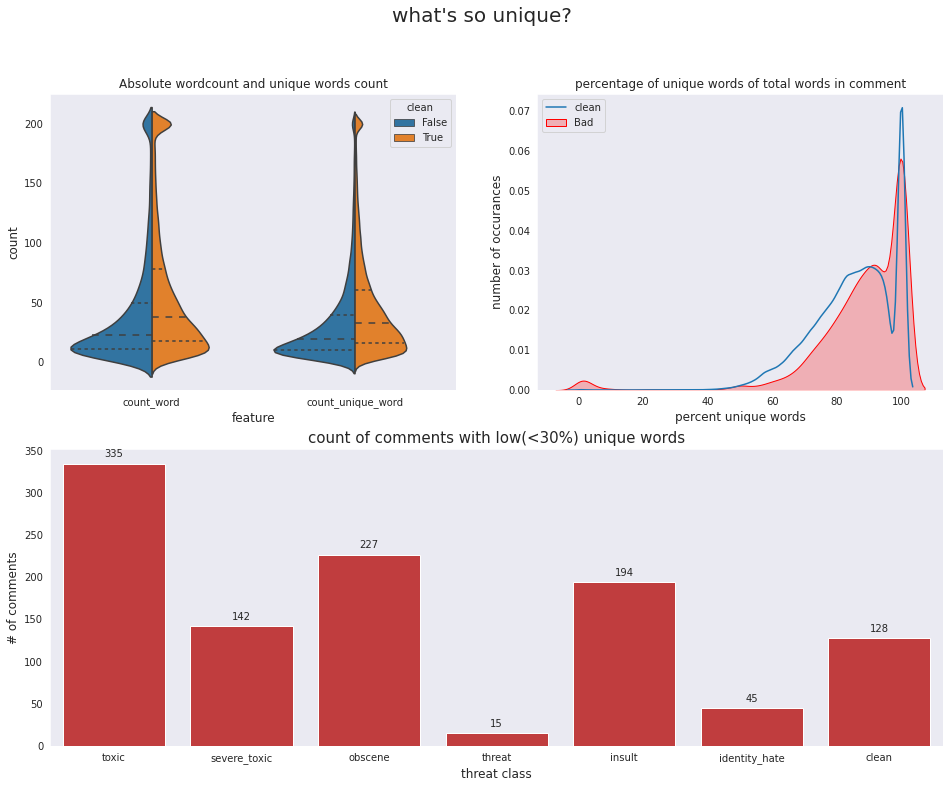

In [29]:
plt.figure(figsize = (16,12))
plt.suptitle("what's so unique?", fontsize = 20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2), (0,0))
sns.violinplot(x = "variable", y = "value", hue = "clean", data = temp_df, split = True, inner = "quartile")
plt.title("Absolute wordcount and unique words count")
plt.xlabel("feature", fontsize = 12)
plt.ylabel("count", fontsize = 12)

plt.subplot2grid((2,2), (0,1))
plt.title("percentage of unique words of total words in comment")
ax = sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label = "Bad", shade = True, color = "r")

ax = sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label = "clean")
plt.legend()
plt.ylabel("number of occurances", fontsize = 12)
plt.xlabel("percent unique words", fontsize = 12)

x= spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2), (1,0), colspan = 2)
plt.title("count of comments with low(<30%) unique words", fontsize = 15)
ax = sns.barplot(x=x.index, y = x.values, color = color[3])

# text label 추가
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha = "center", va="bottom")

plt.xlabel("threat class", fontsize = 12)
plt.ylabel("# of comments", fontsize = 12)
plt.show()

__단어 카운트 vs 고유 단어 카운트:__  
깨끗하고 유해한 댓글에서 단어 수와 고유단어 수의 평균에 눈에 띄는 변화가 있습니다.

차트 설명 : 첫 번째 차트는 분할 바이올린 차트입니다. 이는 범주형 변수를 기반으로 바이올린을 중앙에서 분할할 수 있는 기존 상자 차트/바이올린 차트의 변형입니다

__고유 단어 카운트 퍼센트__  


0\~10% 표시 근처에 부풀어 오른 부분이 있는데, 이는 단어의 다양성이 거의 포함되지않은 많은 수의 유독성 댓글을 나타냅니다.  
차트 설명 : 두 번재 차트는 깨끗한 comment와 유해한 주석 모두에 대해 수행된 주석의 모든 단어중 고유한 단어의 백분율에 대한 두 개의 커널 밀도 추정 플롯의 오버레이(겹치는?)입니다
깨끗한 comment의 수가 데이터 세트를 지배하지만(~90%) 스팸인 깨끗한 댓글은 75개뿐이므로 유해한 댓글의 강력한 지표가 됩니다.

### spammer가 더 유해하다
놀랍지 않습니다. 깨끗하고 유해한 스팸 메시지를 보겠습니다

In [30]:
print("깨끗한 스팸 예시")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("유해한 스팸 예시")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

깨끗한 스팸 예시
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Province
 Cities,

### 스팸은 모델에게도 치명적입니다.
정상적인 단어 수의 피쳐를 포함하도록 모델을 설계하는 경우 이러한 스팸 항목은 좋지 않습니다. 우리 모델이 댓글에서 "mitt romney"라는 단어를 선택하여 독성이 있는 것으로 분류한 시나리오를 상상해보세요.

### 유출 특성
주의 : 이러한 기능을 포함하면 이 특정 시나리오에서 더 나은 성능을 발휘하는 데 도움이 될 수 있지만 최종 모델/범용 모델에 추가하는 것은 의미가 없습니다.

여기서 우리는 정규표현식 조건과 일치하는 카운트 변수를 생성하기 위해 고유한 커스텀 카운트 벡터라이저를 생성합니다

In [31]:
# 유출 특성
df["ip"] = df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", str(x)))
# ip 주소 카운트
df["count_ip"] = df["ip"].apply(lambda x: len(x))

# link
df["link"] = df["comment_text"].apply(lambda x : re.findall("http://.*com", str(x)))
# link 카운트
df["count_links"] = df["link"].apply(lambda x: len(x))

# article ids
df["article_id"] = df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$", str(x)))
df["article_id_flag"] = df.article_id.apply(lambda x: len(x))

# username
# 매칭 형식 [[User: ---------- ]]
df["username"] = df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|", str(x)))
# username mentions의 수
df["count_usernames"] = df["username"].apply(lambda x: len(x))
# 피쳐가 생성되었는지 확인해보세요
# df.username[df.count_usernames>0]

# 유출 ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x: str(x)))

# 유출 username
cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x: str(x)))

In [32]:
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [33]:
# 이름 일부 체크
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

### 유출 특성 안정성
테스트 세트를 예측하는 데 유용성을 확인하기 위해 유출 기능의 재발생을 확인합니다.  
유출 기능 안정성에 대한 논의

In [34]:
leaky_feats = df[["ip", "link","article_id", "username","count_ip","count_links", "count_usernames", "article_id_flag"]]
leaky_feats_train = leaky_feats.iloc[:train.shape[0]]
leaky_feats_test = leaky_feats.iloc[train.shape[0]:]

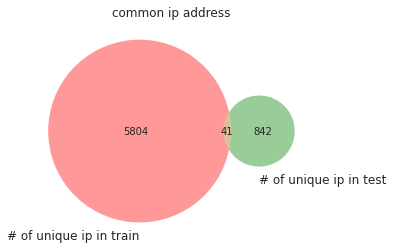

In [35]:
# ip가 없는 항목 필터링
train_ips = leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips = leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
# train 및 test 세트에서 고유한 ip 목록 얻기
train_ip_list = list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list = list(set([a for b in test_ips.tolist() for a in b]))

# 일반 요소 획득
common_ip_list = list(set(train_ip_list).intersection(test_ip_list))
plt.title("common ip address")
venn.venn2(subsets=(len(train_ip_list), len(test_ip_list), len(common_ip_list)), set_labels = ( \
                        "# of unique ip in train", "# of unique ip in test"))
plt.show()

.intersection 을 통해 교집합을 구할 수 있음
단순히 교집합 뿐만이 아니라 이외 집합에 대한 값도 구할 수 있음

venn관련
링크 : https://breakout-theworld.tistory.com/3
링크에서는 intersection을 사용하지 않아도 교집합이 포함되는 것이 확인됨  

순서 : venn2(subsets = (왼쪽만해당, 오른쪽만해당, 양쪽모두해당)

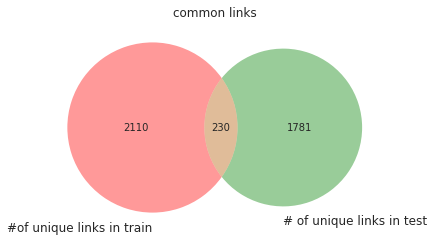

In [36]:
# 링크가 없는 항목 필터링
train_links = leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links = leaky_feats_test.link[leaky_feats_test.count_links!=0]
# train test세트에서 고유한 ip 목록 가져오기
train_links_list = list(set([a for b in train_links.tolist() for a in b]))
test_links_list = list(set([a for b in test_links.tolist() for a in b]))

# 일반 요소 획득
common_links_list = list(set(train_links_list).intersection(test_links_list))
plt.title("common links")
venn.venn2(subsets=(len(train_links_list), len(test_links_list), len(common_links_list)), set_labels = ("#of unique links in train", "# of unique links in test"))
plt.show()

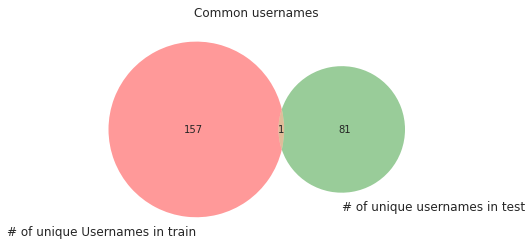

In [37]:
# 사용자가 없는 항목 필터링
train_users = leaky_feats_train.username[leaky_feats_train.count_usernames!= 0]
test_users = leaky_feats_test.username[leaky_feats_test.count_usernames!= 0]
# train test에서 고유한 ip 목록 가져오기 
train_users_list = list(set([a for b in train_users.tolist() for a in b]))
test_users_list = list(set([a for b in test_users.tolist() for a in b]))

# 일반 요소 획득
common_users_list = list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

피쳐 안정성 (aka = 알다시피) test데이터와 train 데이터의 재발생은 최소화 된 것 같습니다.
피쳐 엔지니어링에서 테스트 및 교육을 위해 교차점(에 : 공통ip/ 링크)을 사용할 수 있습니다

# wikipedia blocked_ips

In [38]:
#https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

# 다시 시작

In [39]:
train_ip_list = list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list = list(set([a for b in test_ips.tolist() for a in b]))

# 일반 요소 획득
blocked_ip_list_train = list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test = list(set(test_ip_list).intersection(blocked_ips))

print("train에는", len(blocked_ip_list_train), "개의 블록된 ip가 있습니다")
print("test에는", len(blocked_ip_list_test), "개의 블록된 ip가 있습니다")

train에는 6 개의 블록된 ip가 있습니다
test에는 0 개의 블록된 ip가 있습니다


흥미롭지만 다소 중요하지 않은 발견입니다. 전체 댓글에서 차단된 ip가 6개가 있습니다. 아무튼 데이터 세트 정리를 하겠습니다

In [40]:
end_time = time.time()
print("leaky feats까지 총 시간", end_time-start_time)

leaky feats까지 총 시간 77.32611155509949


### corpus 정리:
카운트 기능을 생성하기 전에 깨끗한 데이터 세트를 사용하는 것은 중요합니다

In [41]:
corpus = merge.comment_text

# stopwords

In [42]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

# 이어서

In [43]:
def clean(comment):
    """
    comment를 받고 깨끗한 단어 목록을 반환합니다
    """
    # 소문자로 변형합니다
    comment = comment.lower()
    # \n 제거
    comment = re.sub("\\n","",comment)
    # ip, user와 같은 유출 요소 제거
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # useranmes 제거
    comment = re.sub("\[\[.*\]","",comment)

    # 문장을 단어로 나누기
    words = tokenizer.tokenize(comment)

    # 작은따옴표 대체
    # 기본 사전 조회
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]

    clean_sent = " ".join(words)
    # 영숫자, 숫자가 아닌 모든 문자 제거
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [44]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [45]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [46]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [47]:
clean_corpus = corpus.apply(lambda x: clean(x))
end_time  = time.time()
print("cleaning까지의 시간은", end_time-start_time)

cleaning까지의 시간은 273.09042596817017


# 직접 피쳐
### 횟수 기반 피쳐(unigram)

단어의 빈도 분포를 기반으로 몇 가지 피쳐를 만들 수 있습니다. 처음에는 한 번에 하나씩 단어를 사용하는 것을 고려해보겠습니다.

sklearn은 count하는 3가지 방법을 제공합니다. 세 가지 모두 먼저 단어 사전을 만든 다음 사전에 있는 문장에 대한 단어 개수의 희소 행렬을 만듭니다.

- countvectorizer
    - text corpus에 있는 각 단어의 빈도 수로 행렬을 만듭니다
- tf-idf vectorizer
    - tf - 단어 빈도 - 텍스트 corpus의 단어 수
    - idf - 문서역빈도 - 너무 빈번한 단어에 벌점을 줍니다. 정규화라고 생각할 수 있습니다.
- hashing vectorizer
    - 어휘사전 대신 해시맵을 생성합니다
    - 이를 통해 더큰 corpus에 대해 더 큰 text에 대해 빠르게 확장할 수 있습니다.
    - 여러 스레드에서 병렬화가 가능합니다


여기에서는 tf-idf를 사용합니다.   
참고 : 우리가 생성하는 어휘가 테스트 세트에 고유한 단어를 놓치지 않도록 하기 위해서 train, test세트의 텍스트를 모두 포함하는 데이터 프레임 병합을 사용합니다.

In [48]:
### Unigrams -- TF-IDF 
# tf-idf를 위한 추천 세팅 -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

# 몇몇 파라미터에 대한 세부적인 설명
# min_df=10 --- 10번 미만으로 등장한 단어는 무시합니다
# max_features=None  --- 가능한 많은 단어를 생성합니다
    # 메모리 문제로 10000개로 설정합니다
# analyzer='word'  --- 단어에서 기능만들기(char도 사용가능합니다)
# ngram_range=(1,1)  --- 한 번에 한 단어만 사용(유니그램)
# strip_accents='unicode' -- 억양 제거
# use_idf=1,smooth_idf=1 --- idf 가능
# sublinear_tf=1   --- 준 선형 tf 스케일링 적용, 예: replace tf with 1 + log(tf)

# temp 설정을 min = 200으로 설정하여 커널에서 상위 피쳐를 쉽게 실행할 수 있습니다.
# 더 나은 결과를 얻으려면 min = 10으로 변경하세요
start_unigrams = time.time()
tfv = TfidfVectorizer(min_df = 200,  max_features = 10000, 
            strip_accents = 'unicode', analyzer = 'word',ngram_range = (1,1),
            use_idf = 1,smooth_idf = 1,sublinear_tf = 1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [49]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n= 25):
    """
    행에서 상위 n 개의 tf-idf의 값을 가져오고 해당 피쳐 이름과 함께 반환합니다.
    """
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ["feature", "tfidf"]
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n= 25):
    """
    특정 문서의 상위 tf idf 피쳐
    """
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf = 0.1, top_n = 25):
    """
    행에 있는 문서 중에서 평균적으로 가장 중요한 상위 n개의 피쳐를 반환합니다.
    grp_ids의 인덱스로 식별됩니다.
    """
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis = 0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# 다중 label 다중 클래스용으로 수정됨
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n = 20):
    """
    각 df가 top_n 피쳐와 평균 tfidf값을 보유하는 dfs목록을 반환합니다. 동일한 클래스 라벨을 가진 문서에서 계산됩니다
    """
    dfs = []
    cols = train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col] == 1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf = min_tfidf, top_n = top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [50]:
# 유니그램에서 top n개 얻기
tfidf_top_n_per_lass = top_feats_by_class(train_unigrams, features)

end_unigrams = time.time()

print("유니그램에서의 총 시간", end_unigrams - start_unigrams)
print("유니그램까지의 총 시간", end_unigrams-start_time)

유니그램에서의 총 시간 30.69840121269226
유니그램까지의 총 시간 303.80042123794556


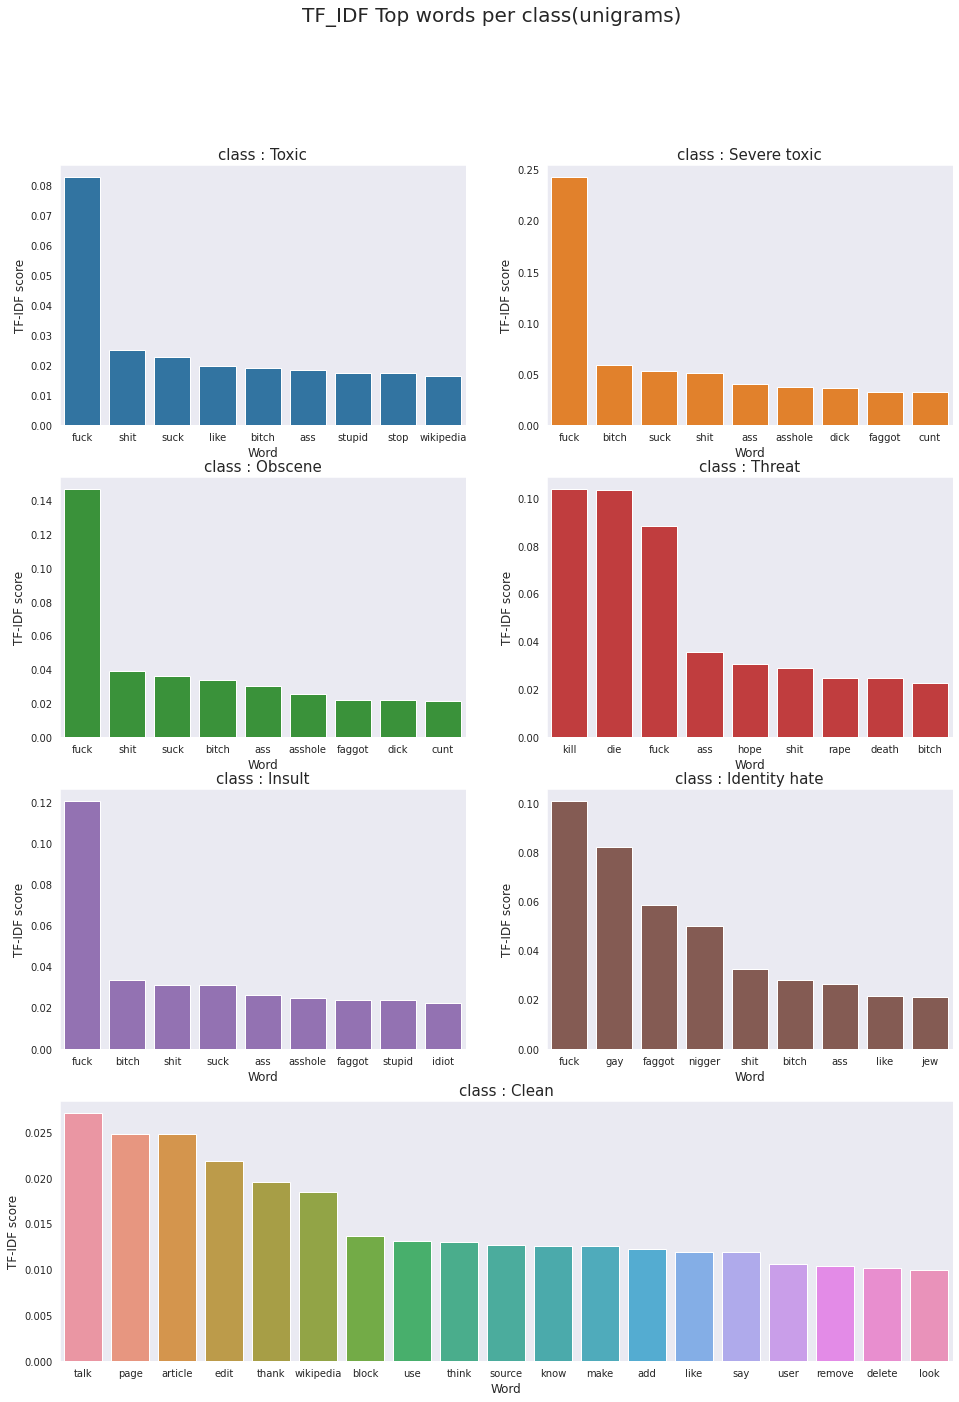

In [51]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [52]:
# temp 설정을 min = 150으로 설정하여 커널에서 상위 기능 섹션을 실행할 수 있습니다.
# 더 나은 결과를 얻으려면 min = 10으로 다시 변경
tfv = TfidfVectorizer(min_df = 150, max_features = 30000,
                      strip_accents  = "unicode", analyzer = "word", ngram_range=(2,2),
                      use_idf = 1, smooth_idf = 1, sublinear_tf=1,
                      stop_words = "english")

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
# 바이그램에서 top n개 획득
tfidf_top_n_per_lass = top_feats_by_class(train_bigrams, features)

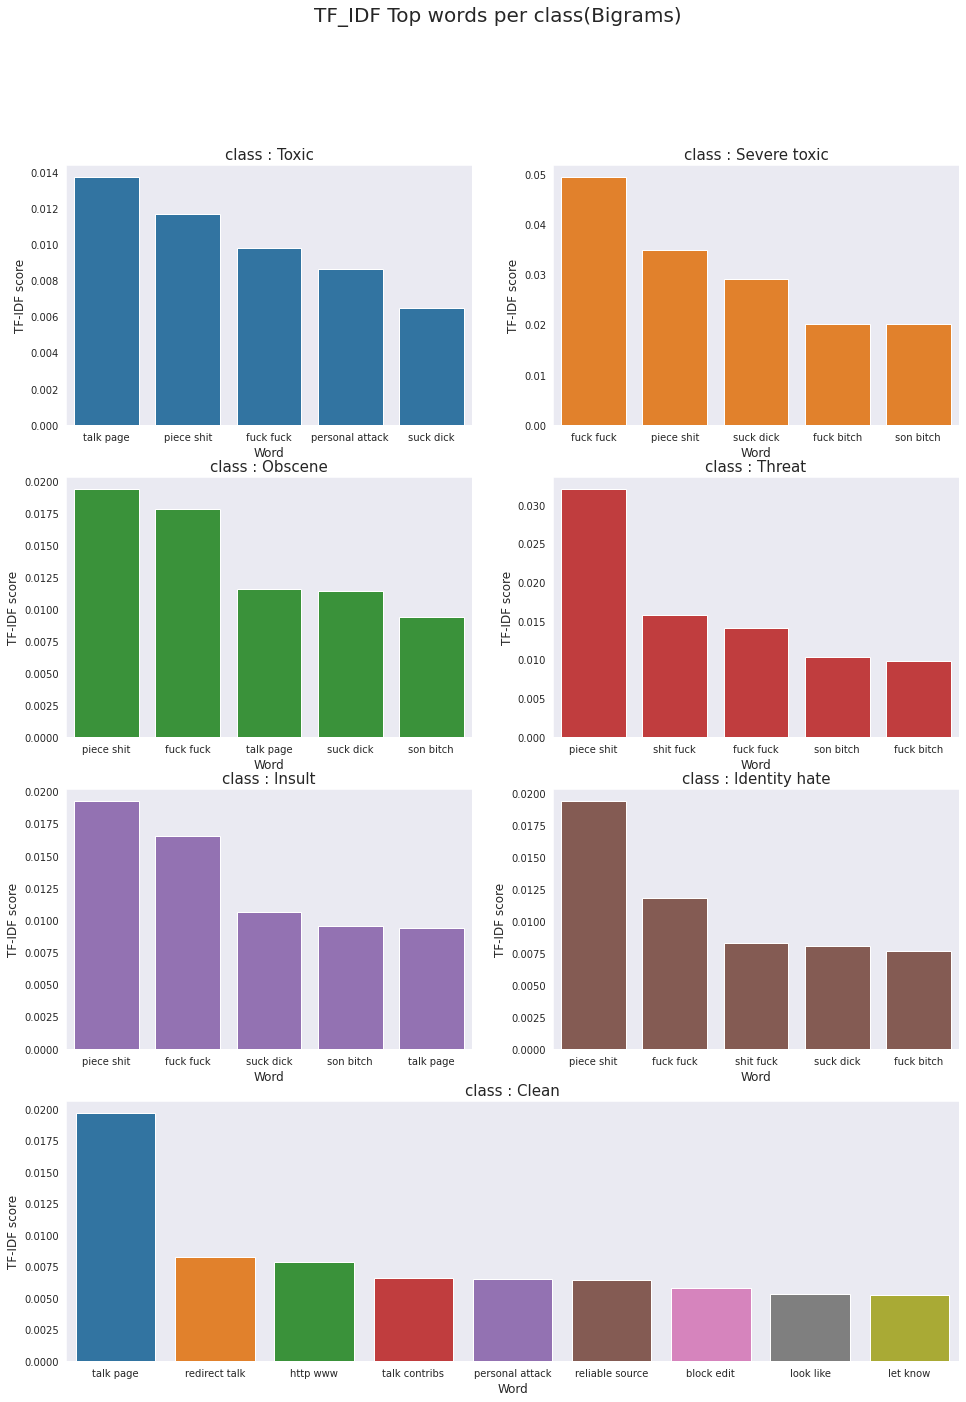

In [53]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [54]:
end_time = time.time()
print("바이그램까지의 전체 시간은", end_time - start_time)

바이그램까지의 전체 시간은 362.4589412212372


In [55]:
tfv = TfidfVectorizer(min_df = 100,  max_features = 30000, 
            strip_accents ='unicode', analyzer ='char',ngram_range = (1,4),
            use_idf = 1,smooth_idf = 1,sublinear_tf = 1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time = time.time()
print("chargram까지의 총 시간은 ",end_time - start_time)

chargram까지의 총 시간은  702.9819300174713


# 베이스 모델:

In [56]:
# AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
# custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [57]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

# 불균형으로 인한 Strat k fold due 
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

# 여기서부터 실행되지않고 종료됩니다. 실행은 이 부분 전까지만 하겠습니다

In [ ]:
# 간접기능 --- 메타 기능
print("간접기능만 사용")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

In [ ]:
importance[0][0]

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [ ]:
from scipy.sparse import scr_matrix, hstack

# 모든 직접 피쳐 사용
print("유출특성을 제외한 모든 특성 사용")
target_x  = hstack((train_bigrams, train_charngrams, train_unigrams, train_feats[SELECTED_COLS])).tocsr()

end_time = time.time()
print("매트릭스 생성까지의 총 시간", end_time - start_time)

In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)